In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from colorcloud.behley2019iccv import plot_projections
from colorcloud.cheng2023TransRVNet import TransVRNet
from colorcloud.cheng2023TransRVNet import TransRVNet_loss
from colorcloud.cheng2023TransRVNet import RandomRotationTransform
from colorcloud.cheng2023TransRVNet import RandomDroppingPointsTransform
from colorcloud.cheng2023TransRVNet import RandomSingInvertingTransform
from colorcloud.behley2019iccv import SemanticKITTIDataset
from colorcloud.behley2019iccv import ProjectionTransform
from colorcloud.behley2019iccv import ProjectionToTensorTransform
from colorcloud.behley2019iccv import SphericalProjection
from colorcloud.behley2019iccv import ProjectionVizTransform

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.transforms import v2
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.loggers import WandbLogger
from torchmetrics.classification import Accuracy
from torchmetrics.segmentation import MeanIoU
from torchmetrics.classification import Dice
from torchmetrics.classification import MulticlassF1Score

import time
import numpy as np
from datetime import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Convolutions' Parameters

In [4]:
mrciam_p = {
    "p1": {
        "b1_in": 1,
        "b1_out1": 32,
        "b1_out2": 32,
        "b1_out3": 32,
        "b2_in": 64,
        "b2_out": 64,
        "b3_in": 64,
        "b3_out1": 64,
        "b3_out2": 64,
        "b3_out3": 64,
        "output": 64,
    },
    "p2": {
        "b1_in": 3,
        "b1_out1": 32,
        "b1_out2": 32,
        "b1_out3": 32,
        "b2_in": 64,
        "b2_out": 64,
        "b3_in": 64,
        "b3_out1": 64,
        "b3_out2": 64,
        "b3_out3": 64,
        "output": 64,
    },
    "output_conv": 192
}

encoder_p = {
    "module_1": {
        "in_channels": 192,
        "conv2_in_channels": 128,
        "conv2_out_channels": 256,
        "dilated_conv_out_channels": 256,
        "residual_out_channels": 256
    },
    "module_2": {
        "in_channels": 256,
        "conv2_in_channels": 256,
        "conv2_out_channels": 256,
        "dilated_conv_out_channels": 256,
        "residual_out_channels": 256
    }
}

decoder_p = {
    "in_channels": 264,
    "conv2_in_channels": 128,
    "dilated_conv_in_channels": 128,
    "dilated_conv_out_channels": 64,
    "output": 32
}

p_bntm = {
    "window_size": (4,4),
    "embed_dim": int(encoder_p["module_2"]["residual_out_channels"]/8)
}

# Visualization

In [5]:
def plot_projections(img, label):
    _, axs = plt.subplots(6, 1, figsize=(20,10), layout='compressed')
    for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'r', 'd', 'label'])): # type: ignore
        if i < 5:
            ax.imshow(img[:,:,i])
        else:
            ax.imshow(label)
        ax.set_title(title)
        ax.axis('off')

In [6]:
data_path = '/workspace/data'
train_dataset = SemanticKITTIDataset(data_path=data_path, split='train')

In [7]:
proj = SphericalProjection(fov_up_deg=3., fov_down_deg=-25., W=1024, H=64)

scaling_values = {
    "x" : {"min": -150., "max":150.},
    "y" : {"min": -150., "max":150.},
    "z" : {"min": -10., "max":30.},
    "r" : {"min": 0., "max":1.},
    "d" : {"min": 0., "max":130.}
}

aug_tfms = v2.Compose([
    RandomDroppingPointsTransform(),
    RandomRotationTransform(),
    RandomSingInvertingTransform(),
    ProjectionTransform(proj),
    ProjectionVizTransform(train_dataset.color_map_rgb_np, train_dataset.learning_map_inv_np, scaling_values),
])

train_dataset.set_transform(aug_tfms)

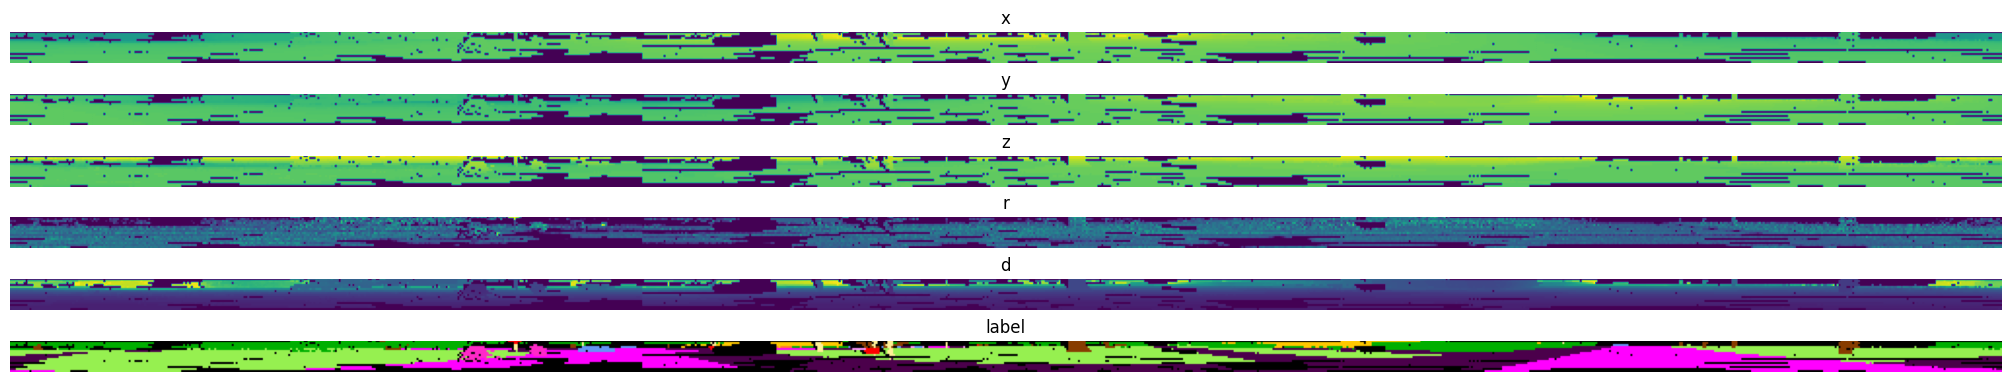

In [8]:
index = list(range(0, 64, 4))
item = train_dataset[100]
img = item['frame'][index,:,:]
label = item['label'][index,:,:]

plot_projections(img, label)

# Pytorch Training

In [9]:
data_path = '/workspace/data'
train_dataset = SemanticKITTIDataset(data_path=data_path, split='train')
val_dataset = SemanticKITTIDataset(data_path=data_path, split='valid')
test_dataset = SemanticKITTIDataset(data_path=data_path, split='test')

print("Size of train dataset: ", len(train_dataset))
print("Size of val dataset: ", len(val_dataset))
print("Size of test dataset: ", len(test_dataset))

Size of train dataset:  5662
Size of val dataset:  2202
Size of test dataset:  1862


In [10]:
proj = SphericalProjection(fov_up_deg=3., fov_down_deg=-25., W=1024, H=64)
scaling_values = {
    "x" : {"min": -150., "max":150.},
    "y" : {"min": -150., "max":150.},
    "z" : {"min": -10., "max":30.},
    "r" : {"min": 0., "max":1.},
    "d" : {"min": 0., "max":130.}
}
aug_tfms = v2.Compose([
    RandomDroppingPointsTransform(),
    RandomRotationTransform(),
    RandomSingInvertingTransform(),
    ProjectionTransform(proj),
    ProjectionToTensorTransform(),
])

train_dataset.set_transform(aug_tfms)
val_dataset.set_transform(aug_tfms)
test_dataset.set_transform(aug_tfms)

In [11]:
batch_size = 1

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [12]:
# steps
n_epochs = 3
train_steps = len(train_loader) // batch_size
val_steps = len(val_loader) // batch_size
test_steps = len(test_loader) // batch_size
total_steps = train_steps * n_epochs

H = {"train_loss": [], "val_loss": []} # store loss history

model = TransVRNet(mrciam_p, encoder_p, decoder_p, p_bntm, N_CLASSES=20, using_reflectance=True).to(device)
# loss function
loss_func = TransRVNet_loss(device=device, file_name_yaml='semantic-kitti.yaml')
# optimizer
opt = AdamW(model.parameters(), lr=5e-4, eps=1e-5, weight_decay=0.0001)
lr_scheduler = OneCycleLR(opt, max_lr=0.002, div_factor=1, final_div_factor=10, steps_per_epoch=total_steps, epochs=30)
# dropout
dropout = torch.nn.Dropout(p=0.2, inplace=False)

# metrics
accuracy = Accuracy(task="multiclass", num_classes=model.n_classes, average=None).to(device)
accuracy_dict = {"train": [], "val": []}

# Mean IoU
miou = MeanIoU(num_classes=model.n_classes, per_class=True).to(device)  # Ajuste aqui
miou_dict = {"train": [], "val": []}

dice = Dice(num_classes=model.n_classes).to(device)
dice_dict = {"train": [], "val": []}

# Multiclass F1 Score
mcf1s = MulticlassF1Score(num_classes=model.n_classes, average=None).to(device)
mcf1s_dict = {"train": [], "val": []}

In [13]:
start_time = time.time()

for epoch in range(n_epochs):

    model.train()

    total_train_loss = 0
    total_val_loss = 0

    for batch in tqdm(train_loader, desc="Training", leave=True):
        train_item = {key: value.to(device) for key, value in batch.items()}
        img = train_item['frame']
        label = train_item['label'].to(torch.int64)
        mask = train_item['mask']

        label[~mask] = 0

        # Separate channels
        xyz = img[:, :3, :, :]
        reflectance = img[:, 3, :, :].unsqueeze(1)
        depth = img[:, 4, :, :].unsqueeze(1)        

        pred = model(xyz, depth, reflectance)

        # Apply dropout
        pred = dropout(pred)

        train_loss = loss_func(pred, label, mask)

        pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
        pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
        mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
        pred_m = pred_f[mask_f, :]
        label_m = label[mask]

        current_train_acc = accuracy(pred_m, label_m)
        accuracy_dict["train"].append(current_train_acc.cpu().detach().numpy())

        pred_labels = torch.argmax(pred, dim=1).to(device)
        mask_miou = (label != 0)
        pred_labels[~mask] = 0
        current_train_miou = miou(pred_labels, label)
        miou_dict["train"].append(current_train_miou.cpu().detach().numpy())
        current_train_dice = dice(pred_labels, label)
        dice_dict["train"].append(current_train_dice.cpu().detach().numpy())
        current_train_mcf1s = mcf1s(pred_labels, label)
        mcf1s_dict["train"].append(current_train_mcf1s.cpu().detach().numpy())
        
        opt.zero_grad()
        train_loss.backward()
        opt.step()

        total_train_loss += train_loss

    with torch.no_grad():

        model.eval()

        for batch in tqdm(val_loader, desc="Eval", leave=True):
            val_item = {key: value.to(device) for key, value in batch.items()}
            img = val_item['frame']
            label = val_item['label'].to(torch.int64)
            mask = val_item['mask']
 
            label[~mask] = 0

            # Separate channels
            xyz = img[:, :3, :, :]
            depth = img[:, 3, :, :].unsqueeze(1)
            reflectance = img[:, 4, :].unsqueeze(1)

            pred = model(xyz, depth, reflectance)

            val_loss = loss_func(pred, label, mask)

            pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
            pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
            mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
            pred_m = pred_f[mask_f, :]
            label_m = label[mask]
            current_val_acc = accuracy(pred_m, label_m)
            accuracy_dict["val"].append(current_val_acc.cpu().detach().numpy())

            pred_labels = torch.argmax(pred, dim=1).to(device)
            mask_miou = (label != 0)
            pred_labels[~mask] = 0
            current_val_miou = miou(pred_labels, label)
            miou_dict["val"].append(current_val_miou.cpu().detach().numpy())
            current_val_dice = dice(pred_labels, label)
            dice_dict["val"].append(current_val_dice.cpu().detach().numpy())
            current_val_mcf1s = mcf1s(pred_labels, label)
            mcf1s_dict["val"].append(current_val_mcf1s.cpu().detach().numpy())
        
            total_val_loss += val_loss

    avg_train_loss = total_train_loss / train_steps
    avg_val_loss = total_val_loss / val_steps

    # Store loss history for graphical visualization
    H["train_loss"].append(avg_train_loss.cpu().detach().numpy()) 
    H["val_loss"].append(avg_val_loss.cpu().detach().numpy())

    print("CURRENT EPOCH: {}/{}".format(epoch + 1, n_epochs))
    print("Train loss: {:.10f}, Val loss {:.4f}".format(avg_train_loss, avg_val_loss))

    model_name = f"../../data/modelos/{epoch}_transRVNet_torch.pt"
    torch.save(model, model_name)

    torch.cuda.empty_cache()  # Opcional: libera cache da GPU após cada época

end_time = time.time()

print("Training took {:.2f}s".format(end_time - start_time))

# tem que acabar em menos de 28min

Training:   0%|          | 0/5662 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training:   0%|          | 12/5662 [00:56<8:18:32,  5.29s/it]

In [ ]:
classes = [
    "unlabeled", "car", "bicycle", "motorcycle", "truck", "other-vehicle",
    "person", "bicyclist", "motorcyclist", "road", "parking", "sidewalk",
    "other-ground", "building", "fence", "vegetation", "trunk", "terrain",
    "pole", "traffic-sign"
]

### Accuracy

In [ ]:
# Transformar o tensor em uma lista e criar pares classe-valor
current_train_acc_cpu = current_train_acc.cpu().numpy()  # Mover para CPU para manipulação
results = zip(classes, current_train_acc_cpu)

# Exibir resultados formatados
print("Accuracy por classe on training:")
for cls, acc in results:
    print(f"{cls:>15}: {acc:.4f}")

# Transformar o tensor em uma lista e criar pares classe-valor
current_val_acc_cpu = current_val_acc.cpu().numpy()  # Mover para CPU para manipulação
results = zip(classes, current_val_acc_cpu)

# Exibir resultados formatados
print("Accuracy por classe on val:")
for cls, acc in results:
    print(f"{cls:>15}: {acc:.4f}")

### Mean IOU

In [ ]:
# Transformar o tensor em uma lista e criar pares classe-valor
current_train_miou_cpu = current_train_miou.cpu().numpy()  # Mover para CPU para manipulação
results = zip(classes, current_train_miou_cpu)

# Exibir resultados formatados
print("Mean IOU por classe on training:")
for cls, acc in results:
    print(f"{cls:>15}: {acc:.4f}")

# Transformar o tensor em uma lista e criar pares classe-valor
current_val_miou_cpu = current_val_miou.cpu().numpy()  # Mover para CPU para manipulação
results = zip(classes, current_val_miou_cpu)

# Exibir resultados formatados
print("Mean IOU por classe on val:")
for cls, acc in results:
    print(f"{cls:>15}: {acc:.4f}")

### Dice

In [ ]:

print("Dice: {:.4f} on training and {:.4f} on testing".format(current_train_dice, current_val_dice))

### F1 Macro

In [ ]:
# Transformar o tensor em uma lista e criar pares classe-valor
current_train_mcf1s_cpu = current_train_mcf1s.cpu().numpy()  # Mover para CPU para manipulação
results = zip(classes, current_train_mcf1s_cpu)

# Exibir resultados formatados
print("F1 Macro por classe on training:")
for cls, acc in results:
    print(f"{cls:>15}: {acc:.4f}")

# Transformar o tensor em uma lista e criar pares classe-valor
current_val_mcf1s_cpu = current_val_mcf1s.cpu().numpy()  # Mover para CPU para manipulação
results = zip(classes, current_val_mcf1s_cpu)

# Exibir resultados formatados
print("F1 Macro por classe on val:")
for cls, acc in results:
    print(f"{cls:>15}: {acc:.4f}")

In [ ]:
# Save model
model_name = "transRVNet_torch.pt"
torch.save(model, model_name)

## Plotting

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

In [ ]:
# Accuracy
plt.style.use("ggplot")
plt.figure()

train_accuracy = [x.sum()/20 for x in accuracy_dict["train"]]
val_accuracy = [x.sum()/20 for x in accuracy_dict["val"]]

plt.plot(train_accuracy, label="train_accuracy")
plt.plot(val_accuracy, label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Steps #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
# Mean IoU
# train_miou = [x.cpu().numpy() for x in miou_dict["train"]]
# val_miou = [x.cpu().numpy() for x in miou_dict["val"]]

train_miou = [x.sum()/20 for x in miou_dict["train"]]
val_miou = [x.sum()/20 for x in miou_dict["val"]]

plt.plot(train_miou, label="train_miou")
plt.plot(val_miou, label="val_miou")
plt.title("Mean IOU")
plt.xlabel("Epoch #")
plt.ylabel("miou")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
train_miou

In [ ]:
train_miou = [x for x in miou_dict["train"]]
val_miou = [x for x in miou_dict["val"]]

# Calcula a média do Mean IoU por classe para o conjunto de treino e validação
mean_train_miou = np.mean(train_miou, axis=0)
mean_val_miou = np.mean(val_miou, axis=0)

# Calcula a média do Mean IoU por classe para o conjunto de treino e validação
# mean_train_miou = mean_train_miou[:13]
# mean_val_miou = mean_val_miou[:13]

# Número de classes
num_classes = mean_train_miou.shape[0]
classes = [f'Classe {i+1}' for i in range(num_classes)]

# Plotando o gráfico de barras para Mean IoU de treino e validação
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(num_classes)

# Barras para treino e validação
plt.bar(index, mean_train_miou, bar_width, label='Treino', color='salmon', edgecolor='black')
plt.bar(index + bar_width, mean_val_miou, bar_width, label='Validação', color='skyblue', edgecolor='black')

# Configuração dos eixos e títulos
plt.xlabel('Classes')
plt.ylabel('Mean IoU')
plt.title('Mean IoU Médio por Classe para Treino e Validação')
plt.xticks(index + bar_width / 2, classes, rotation=45)
plt.legend()


In [ ]:
# Dice
train_dice = [x for x in dice_dict["train"]]
val_dice = [x for x in dice_dict["val"]]

plt.plot(train_dice, label="train_dice")
plt.plot(val_dice, label="val_dice")
plt.title("Dice")
plt.xlabel("Epoch #")
plt.ylabel("dice score")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
# F1 Macro
train_mcf1s = [x.sum()/20 for x in mcf1s_dict["train"]]
val_mcf1s = [x.sum()/20 for x in mcf1s_dict["val"]]

plt.plot(train_mcf1s, label="train_mcf1s")
plt.plot(val_mcf1s, label="val_mcf1s")
plt.title("F1 Macro")
plt.xlabel("Epoch #")
plt.ylabel("mcf1s score")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Vizualization

In [ ]:
model = torch.load('transRVNet_torch.pt', weights_only=False).to(device)
model.eval()

In [ ]:
import torch

def expand_to_64(img):
    N, C, H, W = img.shape
    assert H == 16, "A altura inicial da imagem deve ser 16."
    expanded_img = torch.zeros((N, C, 64, W), device=img.device, dtype=img.dtype)
    for i in range(H):
        expanded_img[:, :, i * 4, :] = img[:, :, i, :]
    return expanded_img

In [ ]:
import torch

def reduce_to_16(img):
    N, C, H, W = img.shape
    assert H == 64, "A altura da imagem deve ser 64 para ser reduzida para 16."
    reduced_img = img.view(N, C, 16, 4, W).mean(dim=3)
    return reduced_img

In [ ]:
def save_imgs(pred, label, mask, num_batch):
    def to_numpy(tensor):
        return tensor[0].detach().cpu().numpy()

    scaling_values = {
    "x" : {"min": -150., "max":150.},
    "y" : {"min": -150., "max":150.},
    "z" : {"min": -10., "max":30.},
    "r" : {"min": 0., "max":1.},
    "d" : {"min": 0., "max":130.}
    }
    
    viz_tfm = ProjectionVizTransform(test_dataset.color_map_rgb_np, test_dataset.learning_map_inv_np, scaling_values)
    pred_np = to_numpy(pred).argmax(0)
    label_np = to_numpy(label)
    mask_np = to_numpy(mask)

    altered_pred_np = pred_np.copy()
    # Set matching predictions to 0
    altered_pred_np[altered_pred_np == label_np] = 0
    
    item = {
        "frame": None,
        "label": pred_np,
        "mask": mask_np,
        "weight": None
    }
    pred_img = viz_tfm(item)["label"]

    item["label"] = altered_pred_np
    altered_pred_img = viz_tfm(item)["label"]
    
    item["label"] = label_np
    label_img = viz_tfm(item)["label"]
    
    img_cmp = np.concatenate((label_img, altered_pred_img, pred_img), axis=0)
    
    img_cmp = img_cmp.astype(np.uint8)
    img_cmp_pil = Image.fromarray(img_cmp)
    save_path = f"../../data/imgs/{num_batch}examples_with_loss.png"
    img_cmp_pil.save(save_path)
     

def inference_with_metrics(model, test_loader, device, i_type=None):
    model.eval()

    total_accuracy = 0
    total_miou = 0
    total_dice = 0
    total_mcf1s = 0

    first = 0
    
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing", leave=True):
            num_batches += 1
            test_item = {key: value.to(device) for key, value in batch.items()}
            img = test_item['frame']
            label = test_item['label'].to(torch.int64)
            mask = test_item['mask']

            label[~mask] = 0

            xyz = img[:, :3, :, :]
            depth = img[:, 3, :, :].unsqueeze(1)
            reflectance = img[:, 4, :].unsqueeze(1)

            #img = expand_to_64(img)
            if i_type:
                img = F.interpolate(img, size=(64,1024), mode=i_type)

            pred = model(xyz, depth, reflectance)

            if i_type:
                #pred = pred[:, :, ::4, :]
                pred = reduce_to_16(pred)
            #pred = reduce_to_16(pred)
            #pred = F.interpolate(pred.float(), size=(16,1024), mode='nearest')
            
            # if num_batches == 1:
            #     print(f"pred: {pred.shape}\n mask: {mask.shape}")
                

            if (num_batches % 50) == 0:
                save_imgs(pred, label, mask, num_batches)

            pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
            pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
            mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
            pred_m = pred_f[mask_f, :]
            label_m = label[mask]

            # import pdb
            # pdb.set_trace()

            pred_labels = torch.argmax(pred, dim=1).to(device)
            mask_miou = (label != 0)
            pred_labels[~mask] = 0

            current_test_acc = accuracy(pred_m, label_m)
            current_test_miou = miou(pred_labels, label)
            current_test_dice = dice(pred_labels, label)
            current_test_mcf1s = mcf1s(pred_labels, label)

            total_accuracy += current_test_acc
            total_miou += current_test_miou
            total_dice += current_test_dice
            total_mcf1s += current_test_mcf1s

    avg_accuracy = total_accuracy / num_batches
    avg_miou = total_miou / num_batches
    avg_dice = total_dice / num_batches
    avg_mcf1s = total_mcf1s / num_batches

    return avg_accuracy, avg_miou, avg_dice, avg_mcf1s

In [ ]:
inference_type = ["normal", "bilinear", "nearest"]
classes = ["unlabeled", "car", "person", "road", "terrain", "vegetation"]
for i_type in inference_type:
    if i_type == "normal":
        avg_acc, avg_miou, avg_dice, avg_f1_macro = inference_with_metrics(model, test_loader, device)
    else:
        avg_acc, avg_miou, avg_dice, avg_f1_macro = inference_with_metrics(model, test_loader, device, i_type)

    print(i_type)
    for iou, item in zip(avg_miou, classes):
        print(f"{item}: {iou*100:.1f}")
    mean = sum(avg_miou[1:6]/len(avg_miou[1:6]))
    print(f"\nmean {mean*100:.1f}")
    print()